```python
####################################################################################################
##### NC State University | Spring 2020
##### Course  : ECE-763 Computer Vision 
##### PROJECT #2 (Haar features, AdaBoost Algorithm, Viola-Jones Face Detection)
#####...............................................................................................
##### Author  : Vinay Kumar
##### UnityID : vkumar24@ncsu.edu
#####...............................................................................................
##### This is a work of © vkumar24@ncsu.edu
####################################################################################################
```

In [847]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


## ```import Necessary Libraries```

In [848]:
## |> include_in_final_source <|
##

import glob
import os
import pprint
import time
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage import io
import skimage
import cv2
from PIL import Image

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sn

## ```Final Source Code```

In [849]:
## |> include_in_final_source <|
## 
## 👍 1. Create Integral Image
## 👍 2. Find the haar features
##      👍 1. Create discriptions for all the different types of haar-like-features
##      👍 2. Write routine to find the features for each image for each feature-type
##
## 👍 3. Initialize weights for each feature
## 👍 4. Find the threshold for each feature
## 👍 5. Normalize the weights before each round-t
## 👍 6. Find the error_h for each feature
## 👍 7. Select the best haar_feature with least error_h for t-th round of AdaBoost

In [850]:
## |> include_in_final_source <|
##
## join the pos and neg data into just one 
# data = {"id0": {"label":1,
#                 "img": np.array(),
#                 "ii_img": np.array(),
#                 },
#         "id1": {"label":1,
#                 "img": np.array(),
#                 "ii_img": np.array(),
#                 },
#         ...
#         ...
#         }

def get_data(path, ctype, extension="jpg", shape=(350,350), resolution=(20,20), as_gray=True, verbose=True):
    """Helper function to create consumable data from the set.
    : path       -> path of the folder where images are present
    : ctype      -> the type of the class the data belongs to (pos / neg)
    : extension  -> extension of the images (.jpg, .png)
    : shape      -> cropping shape of the initial image to capture the face only
    : resolution -> final resolution of the images like (40x40, 20x20, 60x60) 
    : as_gray    -> whether to convert to grayscale or not
    : verbose ->
    """
    data = {}
    idx = 0

    for fname in glob.glob(f"{path}*.{extension}"):
        x_lb = shape[0]
        y_lb = shape[1]
        img = io.imread(fname, as_gray=as_gray)
        if img.shape[0]>=x_lb and img.shape[1]>=y_lb:
            # add the file names
            _id_ = f"{ctype}_{idx}"
            idx += 1
            data[_id_] = {"fname": fname}
            
            xin = np.int((img.shape[0]-x_lb)/2)
            xout = np.int((img.shape[0]+x_lb)/2)
            yin = np.int((img.shape[1]-y_lb)/2)
            yout = np.int((img.shape[1]+y_lb)/2)
            res = cv2.resize(img[xin:xout, yin:yout], dsize=resolution, interpolation=cv2.INTER_CUBIC)
            # res = skimage.transform.resize(img, resolution, anti_aliasing=True)
            data[_id_]["img"] = res

            ## add the labels
            if ctype == "pos":
                data[_id_]["label"] = 1
            elif ctype == "neg":
                data[_id_]["label"] = 0

            ## ⚠️can create the integral_image right here too!!
            ## ⚠️
            ##
    if verbose: print(f"num_data => {len(data.keys())} :: img_shape = {data[_id_]['img'].shape}")
    
    return data

In [851]:
## |> include_in_final_source <|
##
## Create Integral Image

def create_integral_image(img, do_plot=False):
    """Create integral_image:
    : img -> Image
    : do_plot -> Whether to plot the integral_image? or not?
    : Returns::
    : ii_img -> integral image
    """
    t0 = time.time()
    ii_img = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ii_img[i, j] = np.sum(img[:i+1, :j+1])
    # print(f"took {time.time() - t0} seconds")

    ## padding the edges and corners with zeros (boundary conditions)
    tmp = np.zeros((ii_img.shape[0]+2, ii_img.shape[1]+2))
    tmp[1:-1, 1:-1] = ii_img
    ii_img = tmp

    if do_plot:
        plt.figure()
        plt.imshow(ii_img)

    return ii_img



In [852]:
## |> include_in_final_source <|
##

def get_coordinates(coordinates):
    """
    : coordinates ->
    """

    # print("\n:::", coordinates)
    coord = coordinates.copy()
    for k in range(len(coord)):
        if coord[k][0] == coord[k][1]:
            coord[k].pop(0)

    if coord[0] == coord[1]:
        coord.pop(0)

    coord = np.array(coord)
    # print("\n::", coord)

    return coord



In [853]:
## |> include_in_final_source <|
##
## Getting the sum of all pixels in a given coordinate array and the integral_image

def get_sum_pixels(coord, ii_img):
    """
    : coord ->
    : ii_img ->
    """

    if coord.shape[0]==1 and coord.shape[1]==1:
        A = ii_img[coord[0,0,0]-1, coord[0,0,1]-1]
        B = ii_img[coord[0,0,0]-1, coord[0,0,1]]
        C = ii_img[coord[0,0,0], coord[0,0,1]-1]
        D = ii_img[coord[0,0,0], coord[0,0,1]]
    if coord.shape[0]==1 and coord.shape[1]!=1:
        A = ii_img[coord[0,0,0]-1, coord[0,0,1]-1]
        B = ii_img[coord[0,1,0]-1, coord[0,1,1]]
        C = ii_img[coord[0,0,0], coord[0,0,1]-1]
        D = ii_img[coord[0,1,0], coord[0,1,1]]
    if coord.shape[0]!=1 and coord.shape[1]==1:
        A = ii_img[coord[0,0,0]-1, coord[0,0,1]-1]
        B = ii_img[coord[0,0,0]-1, coord[0,0,1]]
        C = ii_img[coord[1,0,0], coord[1,0,1]-1]
        D = ii_img[coord[1,0,0], coord[1,0,1]]
    if coord.shape[0]!=1 and coord.shape[1]!=1:
        A = ii_img[coord[0,0,0]-1, coord[0,0,1]-1]
        B = ii_img[coord[0,1,0]-1, coord[0,1,1]]
        C = ii_img[coord[1,0,0], coord[1,0,1]-1]
        D = ii_img[coord[1,1,0], coord[1,1,1]]
    
    # print(A, B, C, D, "\n-----------\n")

    ## calculate the feature value using the integral image => (A-B-C+D)
    sum_pixels = A-B-C+D
    return sum_pixels


In [854]:
## |> include_in_final_source <|
##
## Create discriptions for all the different types of haar-like-features

class HaarFeatures():
    """
    docstring
    """

    def __init__(self, win_i0, win_j0, win_w, win_h):
        """
        : win_i0 ->
        : win_j0 ->
        : win_w ->
        : win_h ->
        """
        self.feat_type = "default"
        self.win_i0 = win_i0
        self.win_j0 = win_j0
        self.win_w = win_w
        self.win_h = win_h
        self.feats = dict()

    def _init_feats(self):
        pass

    def init_feats(self):
        self._init_feats()



In [855]:
## |> include_in_final_source <|
##

class HaarTypeLR(HaarFeatures):
    """
    Types of haar_features extracted are displayed below:
    ______
    |*||#|
    ------
    ________
    |**||##|
    --------
    ________
    |*||#|
    |*||#|
    --------
    ____________
    |****||####|
    ------------
    ____________
    |****||####|
    |****||####|
    ------------
    and so on ...
    """
    
    def __init__(self, win_i0, win_j0, win_h, win_w):
        """
        docstring
        """
        super().__init__(win_i0, win_j0, win_h, win_w)
        self.feat_type = "haar_lr"

    
    def _init_feats(self):
        for i in range(self.win_i0+1, self.win_h):
            for j in range(self.win_j0+1, self.win_w):
                h = 1
                while i+h <= self.win_h:
                    w = 1
                    while j+2*w <= self.win_w:
                        coords = []
                        coord_A = [[(i, j), (i, j+w-1)], [(i+h-1, j), (i+h-1, j+w-1)]]
                        coord_B = [[(i, j+w), (i, j+2*w-1)], [(i+h-1, j+w), (i+h-1, j+2*w-1)]]

                        coords.append(coord_A)
                        coords.append(coord_B)

                        cx = []
                        for t in range(len(coords)):
                            c = get_coordinates(coords[t])
                            cx.append(c)
                        
                        self.feats[((i,j,h,w), self.feat_type)] = {"feat_type": self.feat_type, 
                                                                   "val": {}, 
                                                                   "error": 0.,
                                                                   "alpha": 0.,
                                                                   "coord_A": cx[0], 
                                                                   "coord_B": cx[1],
                                                                   }
                        
                        cx = []     ## reset the coordinates for next round
                        w += 1      ## increment the weight
                    h += 1          ## increment the height
   
        
    

In [856]:
## |> include_in_final_source <|
##

class HaarTypeLCR(HaarFeatures):
    """
    Types of haar_features extracted are displayed below:
    _________
    |*||#||*|
    ---------
    ___________
    |**||##||**|
    -----------
    _________
    |*||#||*|
    |*||#||*|
    ---------
    __________________
    |****||####||****|
    ------------------
    __________________
    |****||####||****|
    |****||####||****|
    ------------------
    and so on ...
    """
    
    def __init__(self, win_i0, win_j0, win_h, win_w):
        """
        docstring
        """
        super().__init__(win_i0, win_j0, win_h, win_w)
        self.feat_type = "haar_lcr"

    
    def _init_feats(self):
        for i in range(self.win_i0+1, self.win_h):
            for j in range(self.win_j0+1, self.win_w):
                h = 1
                while i+h <= self.win_h:
                    w = 1
                    while j+3*w <= self.win_w:
                        coords = []
                        coord_A = [[(i, j), (i, j+w-1)], [(i+h-1, j), (i+h-1, j+w-1)]]
                        coord_B = [[(i, j+w), (i, j+2*w-1)], [(i+h-1, j+w), (i+h-1, j+2*w-1)]]
                        coord_C = [[(i, j+2*w), (i, j+3*w-1)], [(i+h-1, j+2*w), (i+h-1, j+3*w-1)]]

                        coords.append(coord_A)
                        coords.append(coord_B)
                        coords.append(coord_C)

                        cx = []
                        for t in range(len(coords)):
                            c = get_coordinates(coords[t])
                            cx.append(c)
                        
                        self.feats[((i,j,h,w), self.feat_type)] = {"feat_type": self.feat_type, 
                                                                   "val": {}, 
                                                                   "error": 0.,
                                                                   "alpha": 0.,
                                                                   "coord_A": cx[0], 
                                                                   "coord_B": cx[1],
                                                                   "coord_C": cx[2],
                                                                   }
                        
                        cx = []     ## reset the coordinates for next round
                        w += 1      ## increment the weight
                    h += 1          ## increment the height
   
        
    

In [857]:
## |> include_in_final_source <|
##

class HaarTypeTB(HaarFeatures):
    """
    Types of haar_features extracted are displayed below:
    ___
    |*|
    |#|
    ---
    ___
    |*|
    |*|
    |#|
    |#|
    ---
    ____
    |**|
    |##|
    ----
    ____
    |**|
    |**|
    |##|
    |##|
    ----
    _________
    |*******|
    |#######|
    ---------
    _________
    |*******|
    |*******|
    |#######|
    |#######|
    ---------
    and so on ...
    """

    def __init__(self, win_i0, win_j0, win_w, win_h):
        """
        docstring
        """
        super().__init__(win_i0, win_j0, win_w, win_h)
        self.feat_type = "haar_tb"



    def _init_feats(self):
        for i in range(self.win_i0+1, self.win_h):
            for j in range(self.win_j0+1, self.win_w):
                h = 1
                while i+2*h <= self.win_h:
                    w = 1
                    while j+w <= self.win_w:
                        coords = []
                        coord_A = [[(i, j), (i, j+w-1)], [(i+h-1, j), (i+h-1, j+w-1)]]
                        coord_B = [[(i+h, j), (i+h, j+w-1)], [(i+2*h-1, j), (i+2*h-1, j+w-1)]]

                        coords.append(coord_A)
                        coords.append(coord_B)

                        cx = []
                        for t in range(len(coords)):
                            c = get_coordinates(coords[t])
                            cx.append(c)
                        
                        self.feats[((i,j,h,w), self.feat_type)] = {"feat_type": self.feat_type,
                                                                   "val": {}, 
                                                                   "error": 0.,
                                                                   "alpha": 0.,
                                                                   "coord_A": cx[0], 
                                                                   "coord_B": cx[1],
                                                                   }
                        
                        cx = []     ## reset the coordinates for next round
                        w += 1      ## increment the weight
                    h += 1          ## increment the height



In [858]:
## |> include_in_final_source <|
##

class HaarTypeTCB(HaarFeatures):
    """
    Types of haar_features extracted are displayed below:
    ___
    |*|
    |#|
    |#|
    ---
    ___
    |*|
    |*|
    |#|
    |#|
    |*|
    |*|
    ---
    ____
    |**|
    |##|
    |##|
    ----
    ____
    |**|
    |**|
    |##|
    |##|
    |**|
    |**|
    ----
    _________
    |*******|
    |#######|
    |*******|
    ---------
    _________
    |*******|
    |*******|
    |#######|
    |#######|
    |*******|
    |*******|
    ---------
    and so on ...
    """

    def __init__(self, win_i0, win_j0, win_w, win_h):
        """
        docstring
        """
        super().__init__(win_i0, win_j0, win_w, win_h)
        self.feat_type = "haar_tcb"



    def _init_feats(self):
        for i in range(self.win_i0+1, self.win_h):
            for j in range(self.win_j0+1, self.win_w):
                h = 1
                while i+3*h <= self.win_h:
                    w = 1
                    while j+w <= self.win_w:
                        coords = []
                        coord_A = [[(i, j), (i, j+w-1)], [(i+h-1, j), (i+h-1, j+w-1)]]
                        coord_B = [[(i+h, j), (i+h, j+w-1)], [(i+2*h-1, j), (i+2*h-1, j+w-1)]]
                        coord_C = [[(i+2*h, j), (i+2*h, j+w-1)], [(i+3*h-1, j), (i+3*h-1, j+w-1)]]
                        

                        coords.append(coord_A)
                        coords.append(coord_B)
                        coords.append(coord_C)

                        cx = []
                        for t in range(len(coords)):
                            c = get_coordinates(coords[t])
                            cx.append(c)
                        
                        self.feats[((i,j,h,w), self.feat_type)] = {"feat_type": self.feat_type,
                                                                   "val": {}, 
                                                                   "error": 0.,
                                                                   "alpha": 0.,
                                                                   "coord_A": cx[0], 
                                                                   "coord_B": cx[1], 
                                                                   "coord_C": cx[2],
                                                                   }
                        
                        cx = []     ## reset the coordinates for next round
                        w += 1      ## increment the weight
                    h += 1          ## increment the height



In [874]:
## |>UNDER_CONSTRUCTION<|
## |> include_in_final_source <|
##

class HaarTypeDD(HaarFeatures):
    """
    |>UNDER_CONSTRUCTION<|
    |>Define the rules for changing the h, w <|
    Types of haar_features extracted are displayed below:
    _____
    |*|#|
    |#|*|
    -----
    _____
    |*|#|
    |*|#|
    |#|*|
    |#|*|
    -----
    _______
    |**|##|
    |##|**|
    -------
    _______
    |**|##|
    |**|##|
    |##|**|
    |##|**|
    -------
    and so on ...
    """

    def __init__(self, win_i0, win_j0, win_w, win_h):
        """
        docstring
        """
        super().__init__(win_i0, win_j0, win_w, win_h)
        self.feat_type = "haar_dd"


    def _init_feats(self):
        for i in range(self.win_i0+1, self.win_h):
            for j in range(self.win_j0+1, self.win_w):
                h = 1
                while i+2*h <= self.win_h:
                    w = 1
                    while j+2*w <= self.win_w:
                        coords = []
                        coord_A = [[(i, j), (i, j+w-1)], [(i+h-1, j), (i+h-1, j+w-1)]]
                        coord_B = [[(i, j+w), (i, j+2*w-1)], [(i+h, j+w), (i+h, j+2*w-1)]]
                        coord_C = [[(i+h, j), (i+h, j+w-1)], [(i+2*h-1, j), (i+2*h-1, j+w-1)]]
                        coord_D = [[(i+h, j+w), (i+h, j+2*w-1)], [(i+2*h-1, j+w), (i+2*h-1, j+2*w-1)]]

                        coords.append(coord_A)
                        coords.append(coord_B)
                        coords.append(coord_C)
                        coords.append(coord_D)

                        cx = []
                        for t in range(len(coords)):
                            c = get_coordinates(coords[t])
                            cx.append(c)
                        
                        self.feats[((i,j,h,w), self.feat_type)] = {"feat_type": self.feat_type,
                                                                   "val": {}, 
                                                                   "error": 0.,
                                                                   "alpha": 0.,
                                                                   "coord_A": cx[0], 
                                                                   "coord_B": cx[1], 
                                                                   "coord_C": cx[2],
                                                                   "coord_D": cx[3],
                                                                   }
                        
                        cx = []     ## reset the coordinates for next round
                        w += 1      ## increment the weight
                    h += 1          ## increment the height


In [860]:
## |> include_in_final_source <|
##
## Initialize weights for the data

def init_weights(data, keys, dist="Uniform"):
    """
    : data ->
    : keys ->
    : dist ->
    """
    
    if dist == "Uniform":
        num_train = len(keys)
        for k in keys:
            data[k]["weight"] = 1. / num_train
    if dist == "XUniform":
        C = len(keys)                                   ## total number of classes
        for c_k in keys:
            num = len(c_k)                              ## total number of data items in each class
            for k in c_k:
                data[k]["weight"] = 1. / (C * num)


In [861]:
## |> include_in_final_source <|
##
def create_weak_classifiers(ctypes, i0, j0, w, h):
    """
    : ctypes ->
    : i0 ->
    : j0 ->
    : w ->
    : h ->
    """
    classifiers = {}
    for c in ctypes:
        # print(c)
        if c == "haar_lr":
            h_lr = HaarTypeLR(i0, j0, w, h)
            h_lr.init_feats()
            classifiers.update(h_lr.feats)
        elif c == "haar_lcr":
            h_lcr = HaarTypeLCR(i0, j0, w, h)
            h_lcr.init_feats()
            classifiers.update(h_lcr.feats)
        elif c == "haar_tb":
            h_tb = HaarTypeTB(i0, j0, w, h)
            h_tb.init_feats()
            classifiers.update(h_tb.feats)
        elif c == "haar_tcb":
            h_tcb = HaarTypeTCB(i0, j0, w, h)
            h_tcb.init_feats()
            classifiers.update(h_tcb.feats)
        elif c == "haar_dd":
            h_dd = HaarTypeDD(i0, j0, w, h)
            h_dd.init_feats()
            classifiers.update(h_dd.feats)
    return classifiers
    

In [862]:
## |> include_in_final_source <|
##
def calc_feat_val(data, classifiers, i_id, c_id):
    """
    : data ->
    : classifiers ->
    : i_id -> index(ID) of the image
    : c_id -> index(ID) of the weak-classifier => ((i0,j0,h,w), ctype)
    """
    if classifiers[c_id]["feat_type"] == "haar_lr" or classifiers[c_id]["feat_type"] == "haar_tb":
        sum_A = get_sum_pixels(coord=classifiers[c_id]["coord_A"], ii_img=data[i_id]["ii_img"])
        sum_B = get_sum_pixels(coord=classifiers[c_id]["coord_B"], ii_img=data[i_id]["ii_img"])
        val = sum_A - sum_B
        classifiers[c_id]["val"][i_id] = val
        
    elif classifiers[c_id]["feat_type"] == "haar_lcr" or classifiers[c_id]["feat_type"] == "haar_tcb":
        sum_A = get_sum_pixels(coord=classifiers[c_id]["coord_A"], ii_img=data[i_id]["ii_img"])
        sum_B = get_sum_pixels(coord=classifiers[c_id]["coord_B"], ii_img=data[i_id]["ii_img"])
        sum_C = get_sum_pixels(coord=classifiers[c_id]["coord_C"], ii_img=data[i_id]["ii_img"])
        val = sum_A - sum_B + sum_C
        classifiers[c_id]["val"][i_id] = val
        
    elif classifiers[c_id]["feat_type"] == "haar_dd":
        sum_A = get_sum_pixels(coord=classifiers[c_id]["coord_A"], ii_img=data[i_id]["ii_img"])
        sum_B = get_sum_pixels(coord=classifiers[c_id]["coord_B"], ii_img=data[i_id]["ii_img"])
        sum_C = get_sum_pixels(coord=classifiers[c_id]["coord_C"], ii_img=data[i_id]["ii_img"])
        sum_D = get_sum_pixels(coord=classifiers[c_id]["coord_D"], ii_img=data[i_id]["ii_img"])
        val = sum_A - sum_B + sum_C - sum_D
        classifiers[c_id]["val"][i_id] = val

In [863]:
## |> include_in_final_source <|
##
## get threshold for each weak-classifier

def calc_threshold_and_polarity(data, classifiers):
    """
    : data ->
    : classifiers ->
    """
    
    for c_id in classifiers:
        ## sort the feat_val for each image in ascending order of the feat_val
        sorted_vals = sorted(classifiers[c_id]["val"].items(), key=lambda x:x[1])
        ## calculate the weights of LEFT=(neg_till + pos_all - pos_till) & RIGHT=(pos_till + neg_all -neg_till)
        sum_weights_neg_all = 0
        sum_weights_pos_all = 0
        sum_weights_neg_till = 0
        sum_weights_pos_till = 0
        errs = {}
        polarity = {}
        for i_id in data:
            if data[i_id]["label"] == 0:
                sum_weights_neg_all += data[i_id]["weight"]
            elif data[i_id]["label"] == 1:
                sum_weights_pos_all += data[i_id]["weight"]

        for item in sorted_vals:
            ## item -> (i_id, f_val)
            i_id = item[0]
            if data[i_id]["label"] == 0:
                sum_weights_neg_till += data[i_id]["weight"]
            elif data[i_id]["label"] == 1:
                sum_weights_pos_till += data[i_id]["weight"]
            left = sum_weights_neg_till + sum_weights_pos_all - sum_weights_pos_till
            right = sum_weights_pos_till + sum_weights_neg_all - sum_weights_neg_till
            # errs[i_id] = min(left, right)
            if left <= right:
                errs[i_id] = left
                polarity[i_id] = -1
            elif left > right:
                errs[i_id] = right
                polarity[i_id] = 1
        
        thres_iid = sorted(errs.items(), key=lambda x:x[1])[0][0]
        classifiers[c_id]["threshold"] = classifiers[c_id]["val"][thres_iid]
        classifiers[c_id]["polarity"] = polarity[thres_iid]

def calc_pred_and_error(data, classifiers):
    for c_id in classifiers:
        ## initialize predicted_labels
        classifiers[c_id]["pred_labels"] = {}
        error = 0
        for i_id in classifiers[c_id]["val"]:
            polarity = classifiers[c_id]["polarity"]
            if polarity * classifiers[c_id]["val"][i_id] >= polarity * classifiers[c_id]["threshold"]:
                classifiers[c_id]["pred_labels"][i_id] = 1
            else:
                classifiers[c_id]["pred_labels"][i_id] = 0

            if classifiers[c_id]["pred_labels"][i_id] != data[i_id]["label"]:
                error += data[i_id]["weight"]
        classifiers[c_id]["error"] = error



In [864]:
## |> include_in_final_source <|
##

def get_best_classifier(classifiers):
    """
    : classifiers ->
    """

    sorted_errors = sorted([(c_id, classifiers[c_id]["error"]) for c_id in classifiers], key=lambda x:x[1])
    # sorted_errors = sorted(error_all_feats.items(), key=lambda x:x[1])
    best_c_id = sorted_errors[0][0]
    best_error = sorted_errors[0][1]
    best_alpha = 0.5 * np.log((1-best_error)/best_error)
    classifiers[best_c_id]["alpha"] = best_alpha
    return best_c_id



In [865]:
## |> include_in_final_source <|
##

def update_normalized_weights(data, classifiers, c_id):
    """
    : data ->
    : classifiers ->
    : c_id -> best_c_id
    """
    
    ## calculate the weight normalization factor
    norm_factor = 0
    for i_id in data:
        if classifiers[c_id]["pred_labels"][i_id] != data[i_id]["label"]:
            norm_factor += data[i_id]["weight"] * np.exp(classifiers[c_id]["alpha"])
        elif classifiers[c_id]["pred_labels"][i_id] == data[i_id]["label"]:
            norm_factor += data[i_id]["weight"] * np.exp(-1 * classifiers[c_id]["alpha"])

    ## normalize and update the weights of all data
    for i_id in data:        
        if classifiers[c_id]["pred_labels"][i_id] != data[i_id]["label"]:
            data[i_id]["weight"] *= np.exp(classifiers[c_id]["alpha"])
            data[i_id]["weight"] /= norm_factor
        elif classifiers[c_id]["pred_labels"][i_id] == data[i_id]["label"]:
            data[i_id]["weight"] *= np.exp(-1 * classifiers[c_id]["alpha"])
            data[i_id]["weight"] /= norm_factor


In [886]:
## |> include_in_final_source <|
##
##
## 👍 for iter t <= T:
##      👍 Calculate the vals for each image for each weak-classifier
##      👍 Get threshold
##      👍 Get error
##      👍 Get the best-feature (weak-classifier)
##      👍 Get the best-features's ALPHA
##      👍 Update the weights with normalization
##      👍 Return the (best-feature, ALPHA)
##
##
def run_adaboost(data, classifiers, num_epochs, verbose=True):
    """
    : data ->
    : classifiers ->
    : num_steps ->
    : verbose ->
    """
    
    strong_classifier = []          ## a strong-classifier is an array of multiple weak-classifiers
    for epoch in range(num_epochs):
        cid0 = list(calssifiers.keys())[0]
        if epoch==0 and (len(classifiers[cid0]["val"].keys()) == 0):
            ## calculate "val" only for the 1st epoch (as it remains same after)
            t0 = time.time()
            for c_id in classifiers:
                for i_id in data:
                    ## 👍 calculate the vals for all data
                    calc_feat_val(data=data, classifiers=classifiers, i_id=i_id, c_id=c_id)
            print(f"⏰calc_feat_val() took => {time.time()-t0} seconds @epoch[{epoch}]!!")
        ## 👍 get threshold and error for each weak-classifier
        calc_threshold_and_polarity(data, classifiers)
        calc_pred_and_error(data, classifiers)
        ## 👍 Get the best-feature (weak-classifier), its ALPHA & store it in strong-classifier
        best_c_id = get_best_classifier(classifiers)
        # strong_classifier[best_c_id] = classifiers[best_c_id].copy()
        strong_classifier.append({best_c_id: classifiers[best_c_id].copy()})
        # strong_classifier[t] = classifiers[best_c_id].copy()
        ## 👍 Normalize & update the weights
        update_normalized_weights(data=data, classifiers=classifiers, c_id=best_c_id)
        if verbose:
            print(f"epoch[{epoch}/{num_epochs}] => {best_c_id} " \
                f":: (error->{classifiers[best_c_id]['error']}) " \
                f":: (alpha->{classifiers[best_c_id]['alpha']})")
    return strong_classifier



In [887]:
## |> include_in_final_source <|
##
def draw_classifier(data, strong_classifier, win_h, win_w, i_id):
    """
    : data ->
    : strong_classifier -> 
    : win_h ->
    : win_w ->
    : i_id ->
    """

    for wc in strong_classifier:
        c_id = list(wc.keys())[0]
        classifier_img = np.ones((win_h+2, win_w+2))*255
        # print(classifier_img)

        i0 = c_id[0][0]
        j0 = c_id[0][1]
        h = c_id[0][2]
        w = c_id[0][3]
        c_type = c_id[1]
        if c_type=="haar_lr":
            for i in range(i0, i0+h):
                for j in range(j0, j0+w):
                    classifier_img[i,j] = 125          ## A
                for j in range(j0+w, j0+2*w):
                    classifier_img[i,j] = 0            ## B
        elif c_type=="haar_lcr":
            for i in range(i0, i0+h):
                for j in range(j0, j0+w):
                    classifier_img[i,j] = 125          ## A
                for j in range(j0+w, j0+2*w):
                    classifier_img[i,j] = 0            ## B
                for j in range(j0+2*w, j0+3*w):
                    classifier_img[i,j] = 125          ## C
        elif c_type=="haar_tb":
            for j in range(j0, j0+w):
                for i in range(i0, i0+h):
                    classifier_img[i,j] = 125          ## A
                for i in range(i0+h, i0+2*h):
                    classifier_img[i,j] = 0            ## B
        elif c_type=="haar_tcb":
            for j in range(j0, j0+w):
                for i in range(i0, i0+h):
                    classifier_img[i,j] = 125          ## A
                for i in range(i0+h, i0+2*h):
                    classifier_img[i,j] = 0            ## B
                for i in range(i0+2*h, i0+3*h):
                    classifier_img[i,j] = 125          ## C
        elif c_type=="haar_dd":
            for i in range(i0, i0+h):
                for j in range(j0, j0+w):
                    classifier_img[i,j] = 125          ## A
                for j in range(j0+w, j0+2*w):
                    classifier_img[i,j] = 0            ## B
            for i in range(i0+h, i0+2*h):
                for j in range(j0, j0+w):
                    classifier_img[i,j] = 0            ## C
                for j in range(j0+w, j0+2*w):
                    classifier_img[i,j] = 125          ## D

        plt.figure()
        plt.imshow(data[i_id]["img"], cmap="gray")
        plt.imshow(classifier_img[1:-1, 1:-1], cmap="hot", alpha=0.7)
        plt.title(f"{c_id}, error={wc[c_id]['error']}, alpha={wc[c_id]['alpha']}")
    


In [888]:
## |> include_in_final_source <|
##

class Cascade():
    def __init__(self, strong_classifier=None):
        self.strong_classifier = strong_classifier
    
    def train(self, data, keys, num_epochs, c_types, weight_dist="Uniform", template=(0,0,20,20), verbose=False):
        """
        : data ->
        : c_types -> different types of classifiers (haar-type-classifiers) :: ["haar_lr", "haar_tb", "haar_lcr", "haar_tcb", "haar_dd"]
        : weight_dist -> ::"Uniform" or "XUniform"
        : template -> (i0, j0, h, w) of the window  :: (0,0,20,20)
        : verbose -> :: True or False
        """
        self.num_epochs = num_epochs
        
        t0 = time.time()
        ## 👍 initialize the weights
        # keys = data.keys()
        init_weights(data=data, keys=keys, dist=weight_dist)

        ## 👍 create ALL haar-like-features
        classifiers = create_weak_classifiers(ctypes=c_types, 
                                                   i0=template[0],
                                                   j0=template[1],
                                                   w=template[2],
                                                   h=template[3])
        
        ## write rules for training in each mode-type
        
        if verbose: print(f"<|CASCADE|>|> #classifiers=>{len(classifiers)}")
        self.strong_classifier = run_adaboost(data=data, classifiers=classifiers, num_epochs=self.num_epochs, verbose=verbose)
        if verbose: print(f"Time taken => {time.time()-t0} seconds!!")
        
    
    def test(self, data, mode, verbose=False):
        """
        : data ->
        : mode -> ::["sequential", "committe", "attentional"]
        : verbose ->
        """
        assert len(self.strong_classifier) != 0
        self.mode=mode
        if mode == "sequential":
            allowed_iids = list(data.keys())
            stage = 0
            for wc in self.strong_classifier:
                c_id = list(wc.keys())[0]
                wc[c_id]["val"] = {}           ## reset the garbage from training process
                wc[c_id]["pred_labels"] = {}   ## reset the garbage from training process
                error = 0
                new_allowed_iids = []
                
                for i_id in allowed_iids:
                    calc_feat_val(data=data, classifiers=wc, i_id=i_id, c_id=c_id)
                    polarity = wc[c_id]["polarity"]
                    if polarity * wc[c_id]["val"][i_id] >= polarity * wc[c_id]["threshold"]:
                        wc[c_id]["pred_labels"][i_id] = 1
                        new_allowed_iids.append(i_id)             ## only faces are sent to the next weak-clasifier
                    else:
                        wc[c_id]["pred_labels"][i_id] = 0

                    if wc[c_id]["pred_labels"][i_id] != data[i_id]["label"]:
                        error += 1
                wc[c_id]["stage_test_error"] = error/len(allowed_iids)

                ## update the allowed_iids to be classified by next weak-classifier
                allowed_iids = new_allowed_iids

                if verbose: 
                    print(f"mode=[{mode}]: stage[{stage}]=> passed = [{len(allowed_iids)}/{len(data)}] " \
                        f":: stage_test_error -> {wc[c_id]['stage_test_error']} " \
                        f":: overall_test_error -> {error/len(data)}")
                stage += 1
                
        elif mode == "committee":
            ## if (sum_t(alpha_t * polarity_t * val_t_i) >= sum_t(alpha_t * polarity_t * thresh_t)) => 1 else 0
            pred_xvals = {}
            weighted_committe_threshold = 0
            error = 0
            for wc in self.strong_classifier:
                c_id = list(wc.keys())[0]
                wc[c_id]["val"] = {}           ## reset the garbage from training process
                wc[c_id]["pred_labels"] = {}   ## reset the garbage from training process
                weighted_committe_threshold += wc[c_id]["alpha"] * wc[c_id]["polarity"] * wc[c_id]["threshold"]
                
                for i_id in data.keys():
                    calc_feat_val(data=data, classifiers=wc, i_id=i_id, c_id=c_id)
                    if i_id not in pred_xvals.keys():
                        pred_xvals[i_id] = [wc[c_id]["alpha"] * wc[c_id]["polarity"] * wc[c_id]["val"][i_id]]
                    else:
                        pred_xvals[i_id].append(wc[c_id]["alpha"] * wc[c_id]["polarity"] * wc[c_id]["val"][i_id])
            
            for i_id in data.keys():
                pred_xvals[i_id].append(np.sum(pred_xvals[i_id]))
                
                ## calculate the predicted labels
                if pred_xvals[i_id][-1] >= weighted_committe_threshold:
                    pred_xvals[i_id].append(1)
                    if pred_xvals[i_id][-1] != data[i_id]["label"]: error += 1
                else:
                    pred_xvals[i_id].append(0)
                    if pred_xvals[i_id][-1] != data[i_id]["label"]: error += 1
                    
            ## calculate the "error" for the commitee
            error /= len(data.keys())
            if verbose: 
                    print(f"mode=[{mode}] => overall_test_error -> {error}")
            res = {}
            for iid in pred_xvals.keys():
                res[iid] = pred_xvals[iid][-2]
            return res

    def draw(self, data, i_id, win_h, win_w):
        """
        : data -> used to draw the background overlay
        : i_id -> which image to draw on the background of the classifiers 
        : win_h -> window width
        : win_w -> window height
        """
        draw_classifier(data=data, strong_classifier=self.strong_classifier, win_h=win_h, win_w=win_w, i_id=i_id)


In [890]:
## |> include_in_final_source <|
##
## Draw ROC curve & AUC

def draw_roc_curve(data, mode, classifiers=None, predictions=None):
    """
    : classifiers -> [optional]
    : predictions -> [optional]
    """
    plt.figure()
    plt.title("ROC Curve for all classifiers")
    
    if mode == "sequential":
        idx = 0
        for wc in classifiers:
            c_id = list(wc.keys())[0]
            polarity = wc[c_id]["polarity"]
            iids = sorted(list(wc[c_id]["val"].keys()))
            labels = []
            preds_vals = []
            val_min = 1e6
            val_max = -1e6
            for i_id in iids:
                labels.append(data[i_id]["label"])
                val = wc[c_id]["val"][i_id]
                preds_vals.append(val)
                if val_min > val:
                    val_min = val
                if val_max < val:
                    val_max = val

            D = np.zeros((100, len(iids)+6))
            for i, t in enumerate(np.linspace(val_min, val_max, 100)):
                preds = [int(polarity*p > polarity*t) for p in preds_vals]
                D[i][:-6] = preds

                for j in range(len(D[i])-6):
                    if labels[j] == 1 and D[i, j] == 1:   ## TP
                        D[i,-6] += 1
                    if labels[j] == 1 and D[i, j] == 0:   ## FP
                        D[i,-5] += 1
                    if labels[j] == 0 and D[i, j] == 0:   ## TN
                        D[i,-4] += 1
                    if labels[j] == 0 and D[i, j] == 1:   ## FN
                        D[i,-3] += 1
                if (D[i,-6] + D[i,-3]) != 0:
                    D[i][-2] = D[i,-6] / (D[i,-6] + D[i,-3])   ## TPR
                if (D[i,-5] + D[i,-4]) != 0:
                    D[i][-1] = D[i,-5] / (D[i,-5] + D[i,-4])   ## FPR

            tpr = list(D[:, -2])
            fpr = list(D[:, -1])
            rates = [[f, t] for f, t in zip(fpr, tpr)]
            sorted_rates = np.array(sorted(rates, key=lambda x:x[0])).T

            auc = sklearn.metrics.auc(sorted_rates[0], sorted_rates[1])

            plt.plot(sorted_rates[0], sorted_rates[1], label=f"stage-{idx}: AUC={auc}")
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.legend()
            idx += 1
    elif mode=="committee":
        # predictions -> {i_id: pred_xvals}
        labels = []
        iids = list(sorted(predictions.keys()))
        preds_xvals = []
        val_min = 1e6
        val_max = -1e6
        D = np.zeros((100, len(iids)+6))
        
        for i_id in iids:
            labels.append(data[i_id]["label"])
            xval = predictions[i_id]
            preds_xvals.append(xval)
            if val_min > xval:
                val_min = xval
            if val_max < xval:
                val_max = xval
        for i, t in enumerate(np.linspace(val_min, val_max, 100)):
            preds = [int(p >= t) for p in preds_xvals]
            D[i][:-6] = preds

            for j in range(len(D[i])-6):
                if labels[j] == 1 and D[i, j] == 1:   ## TP
                    D[i,-6] += 1
                if labels[j] == 1 and D[i, j] == 0:   ## FP
                    D[i,-5] += 1
                if labels[j] == 0 and D[i, j] == 0:   ## TN
                    D[i,-4] += 1
                if labels[j] == 0 and D[i, j] == 1:   ## FN
                    D[i,-3] += 1
            if (D[i,-6] + D[i,-3]) != 0:
                D[i][-2] = D[i,-6] / (D[i,-6] + D[i,-3])   ## TPR
            if (D[i,-5] + D[i,-4]) != 0:
                D[i][-1] = D[i,-5] / (D[i,-5] + D[i,-4])   ## FPR
        tpr = list(D[:, -2])
        fpr = list(D[:, -1])
        rates = [[f, t] for f, t in zip(fpr, tpr)]
        sorted_rates = np.array(sorted(rates, key=lambda x:x[0])).T

        auc = sklearn.metrics.auc(sorted_rates[0], sorted_rates[1])

        plt.plot(sorted_rates[0], sorted_rates[1], label=f"{mode}: AUC={auc}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
    plt.show()

 

In [871]:
time.time()

1584919948.5908759

In [891]:
## 🥶🥵⚠️🎉👍⏰

In [873]:
## |> include_in_final_source <|
## 🎉🎉 MASTER CODE 🎉🎉 PART-1 (DATALOADING) 🎉🎉
## 
## 👍 grab the pos & neg training data (windows) and their labels

path_pos_data_train = f"../data/face_train/"
path_neg_data_train = f"../data/bg_train/"
shape=(350, 350)
resolution=(20, 20)

pos_data_train = get_data(path=path_pos_data_train, shape=shape, resolution=resolution, as_gray=True, ctype="pos")
neg_data_train = get_data(path=path_neg_data_train, shape=(20, 20), resolution=resolution, as_gray=True, ctype="neg")
data_train = {**pos_data_train, **neg_data_train}

## 🥵 calculate integral-image for all data
for i_id in data_train.keys():
    ii_img = create_integral_image(data_train[i_id]["img"])
    data_train[i_id]["ii_img"] = ii_img
    


num_data => 300 :: img_shape = (20, 20)
num_data => 879 :: img_shape = (20, 20)


In [896]:
## Cascade|> include_in_final_source <|
## 🚀🚀 MASTER CODE 🚀🚀 PART-2.new (CASCADE training) 🚀🚀
## 
num_epochs = 5
c_types = ["haar_lr", "haar_lcr", "haar_tb", "haar_tcb"]
weight_dist = "Uniform"
# i_id_keys = [list(pos_data_train), list(neg_data_train)]
i_id_keys = data_train.keys()
template = (0,0,20,20)
mode = "sequential"   ## otherwise can use these aswell -> ["committe", "attentional"]

## Build & train a cascade
cascade = Cascade()
cascade.train(data=data_train, keys=i_id_keys, num_epochs=num_epochs, c_types=c_types, weight_dist=weight_dist, template=template, verbose=True)

<|CASCADE|>|> #classifiers=>55860
⏰calc_feat_val() took => 838.880529165268 seconds @epoch[0]!!
epoch[0/5] => ((1, 2, 3, 3), 'haar_lr') :: (error->0.06700593723494487) :: (alpha->1.3168088031597203)
epoch[1/5] => ((1, 13, 3, 1), 'haar_tcb') :: (error->0.09353279631760517) :: (alpha->1.1356213564669195)
epoch[2/5] => ((1, 16, 6, 2), 'haar_lr') :: (error->0.11284739107754822) :: (alpha->1.0309903168286074)
epoch[3/5] => ((8, 16, 4, 1), 'haar_tcb') :: (error->0.16761127545433152) :: (alpha->0.8013260434728907)
epoch[4/5] => ((9, 2, 5, 2), 'haar_lr') :: (error->0.15162335430268106) :: (alpha->0.8609625906865277)
Time taken => 2547.447574853897 seconds!!


In [897]:
## |> include_in_final_source <|
## 🚀🚀 MASTER CODE 🚀🚀 PART-3 (TEST DATA-LOADING) 🚀🚀
## 
## 👍 grab the pos & neg training data (windows) and their labels

path_pos_data_test = f"../data/face_test/"
path_neg_data_test = f"../data/bg_test/"
shape=(350, 350)
resolution=(20, 20)

pos_data_test = get_data(path=path_pos_data_test, shape=shape, resolution=resolution, as_gray=True, ctype="pos")
neg_data_test = get_data(path=path_neg_data_test, shape=(20,20), resolution=resolution, as_gray=True, ctype="neg")
data_test = {**pos_data_test, **neg_data_test}

## 🥵 calculate integral-image for all data
for i_id in data_test.keys():
    ii_img = create_integral_image(data_test[i_id]["img"])
    data_test[i_id]["ii_img"] = ii_img


num_data => 116 :: img_shape = (20, 20)
num_data => 50 :: img_shape = (20, 20)


mode=[sequential]: stage[0]=> passed = [114/166] :: stage_test_error -> 0.24096385542168675 :: overall_test_error -> 0.24096385542168675
mode=[sequential]: stage[1]=> passed = [58/166] :: stage_test_error -> 0.32456140350877194 :: overall_test_error -> 0.22289156626506024
mode=[sequential]: stage[2]=> passed = [55/166] :: stage_test_error -> 0.05172413793103448 :: overall_test_error -> 0.018072289156626505
mode=[sequential]: stage[3]=> passed = [9/166] :: stage_test_error -> 0.8363636363636363 :: overall_test_error -> 0.27710843373493976
mode=[sequential]: stage[4]=> passed = [5/166] :: stage_test_error -> 0.4444444444444444 :: overall_test_error -> 0.024096385542168676


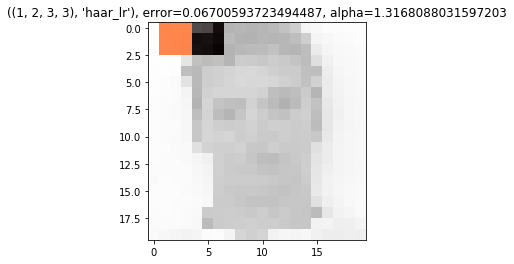

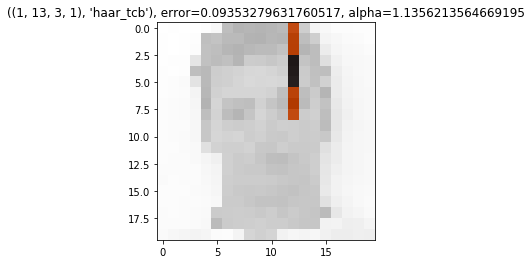

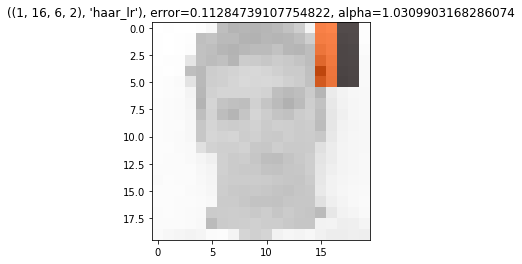

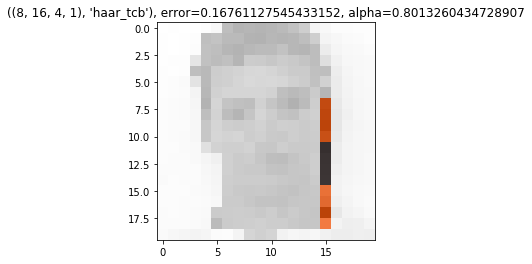

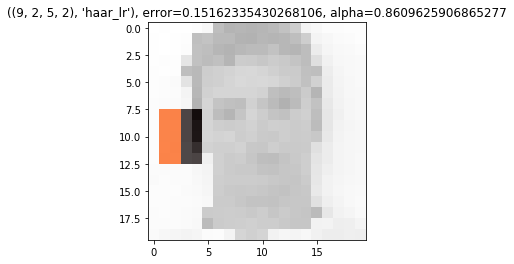

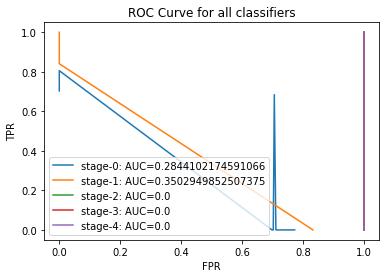

In [898]:
## |> include_in_final_source <|
## 🚀🚀 MASTER CODE 🚀🚀 PART-4 (TEST using trained CASCADE) 🚀🚀
## 
# sc = cascade.strong_classifier              ## <- 🚫CAREFUL: used only for speed-testing to avoid re-training. DONOT include in final_source
# cascade = Cascade(strong_classifier=sc)     ## <- 🚫CAREFUL: used only for speed-testing to avoid re-training. DONOT include in final_source

cascade.test(data=data_test, mode="sequential", verbose=True)
# predictions = cascade.test(data=data_test, mode="committee", verbose=True)

cascade.draw(data_test, "pos_0", 20, 20)

draw_roc_curve(data=data_test, mode="sequential", classifiers=cascade.strong_classifier)
# draw_roc_curve(data=data_test, mode="committee", predictions=predictions)

# ```sandbox (rough work for development)```

In [786]:

num_epochs = 1
c_types = ["haar_dd"]
weight_dist = "Uniform"
template = (0,0,20,20)
mode = "sequential"   ## otherwise can use these aswell -> ["committe", "attentional"]

## Build & train a cascade
cascade1 = Cascade()
cascade1.train(data=data_train, num_epochs=num_epochs, c_types=c_types, weight_dist=weight_dist, template=template, verbose=True)

<|CASCADE|>|> #classifiers=>8100
epoch[0/1] => ((5, 1, 2, 3), 'haar_dd') :: (error->0.03901611535199324) :: (alpha->1.6019914322694553)
Time taken => 185.82044792175293 seconds!!


mode=[sequential]: stage[0]=> passed = [113/166] :: stage_test_error -> 0.10240963855421686 :: overall_test_error -> 0.10240963855421686


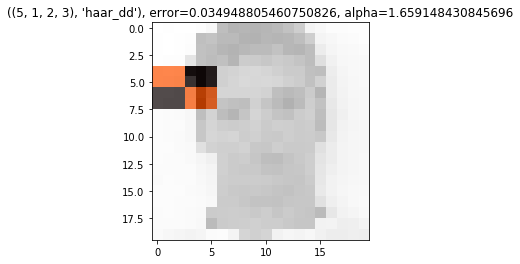

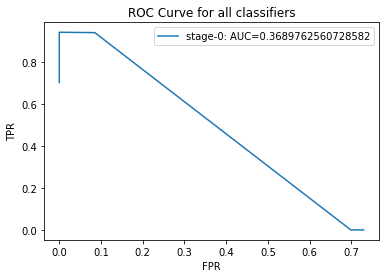

In [846]:

sc = cascade.strong_classifier              ## <- 🚫CAREFUL: used only for speed-testing to avoid re-training. DONOT include in final_source
cascade1 = Cascade(strong_classifier=sc)     ## <- 🚫CAREFUL: used only for speed-testing to avoid re-training. DONOT include in final_source

cascade1.test(data=data_test, mode="sequential", verbose=True)
# predictions = cascade.test(data=data_test, mode="committee", verbose=True)

cascade1.draw(data_test, "pos_0", 20, 20)

draw_roc_curve(data=data_test, mode="sequential", classifiers=cascade1.strong_classifier)
# draw_roc_curve(data=data_test, mode="committee", predictions=predictions)

In [792]:
cascade1.strong_classifier[0][((5, 1, 2, 3), 'haar_dd')].keys()

dict_keys(['feat_type', 'val', 'error', 'alpha', 'coord_A', 'coord_B', 'coord_C', 'coord_D', 'threshold', 'polarity', 'pred_labels', 'stage_test_error'])

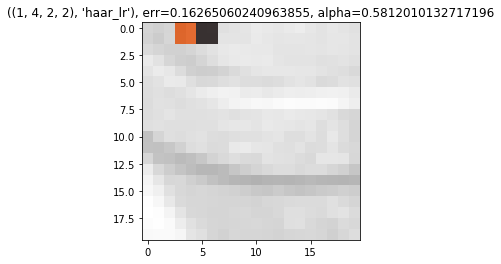

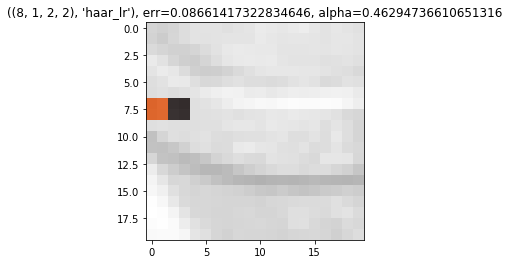

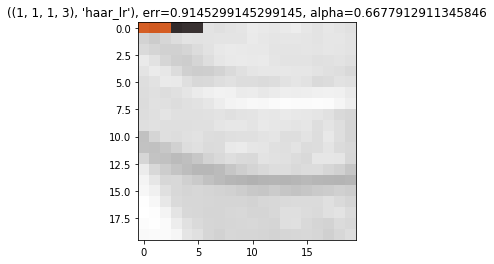

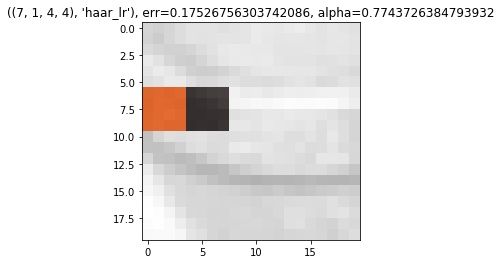

In [551]:
draw_classifier(strong_classifier=cascade.strong_classifier, win_h=template[2], win_w=template[3])


In [159]:
len(classifiers)

34200

In [154]:
from skimage import io
img = io.imread(f"../data/face_test/151-11.jpg", as_gray=True)

(480, 640)

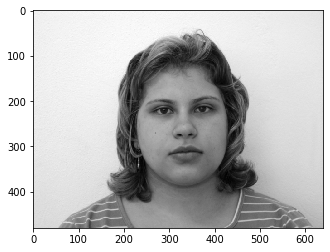

In [155]:
plt.figure()
plt.imshow(img, cmap="gray")
img.shape

(20, 20)

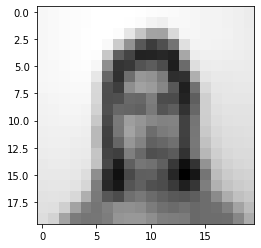

In [159]:
import skimage
res = skimage.transform.resize(img, (20,20), anti_aliasing=True)
plt.figure()
plt.imshow(res,cmap="gray")
res.shape

(20, 20)

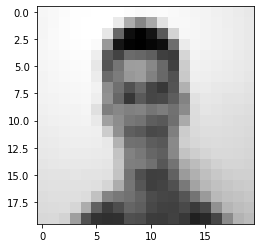

In [169]:
res = skimage.transform.resize(img, (20,20), anti_aliasing=False)
plt.figure()
plt.imshow(data_train["pos_0"]["img"],cmap="gray")
res.shape

In [ ]:
def draw_classifierX(c_id):
    classifier_img = np.zeros((7,7))
    i0 = c_id[0][0]
    j0 = c_id[0][1]
    h = c_id[0][2]
    w = c_id[0][3]
    c_type = c_id[1]
    if c_type=="haar_lr":
        for i in range(i0, i0+h):
            for j in range(j0, j0+w):
                classifier_img[i,j] = 255
            for j in range(j0+w, j0+2*w):
                classifier_img[i,j] = 200
    elif c_type=="haar_tb":
        for j in range(j0, j0+w):
            for i in range(i0, i0+h):
                classifier_img[i,j] = 255
            for i in range(i0+h, i0+2*h):
                classifier_img[i,j] = 200

    plt.figure()
    plt.imshow(classifier_img)
    plt.title(c_id)
    


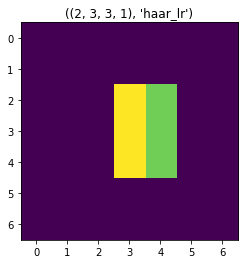

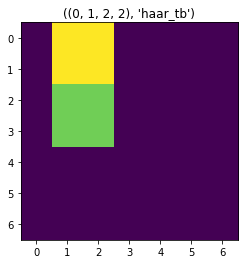

In [ ]:
draw_classifierX(((2,3,3,1), "haar_lr"))
draw_classifierX(((0,1,2,2), "haar_tb"))

In [ ]:
strong_classifier

[((2, 2, 1, 3), 'haar_tb'), ((1, 3, 2, 2), 'haar_tb')]

In [ ]:
classifier_img = np.zeros((5,5))
classifier_img[0,0] = 300
classifier_img[1,1] = 200

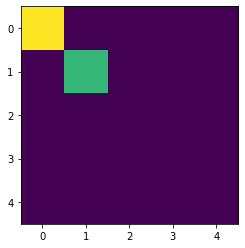

In [ ]:
plt.figure()
plt.imshow(classifier_img)

(40, 40)

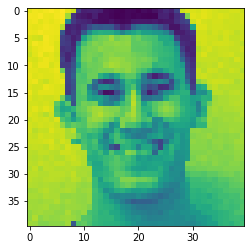

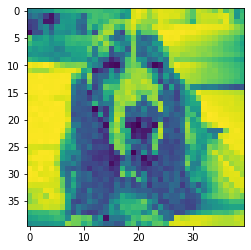

In [ ]:
## |> include_in_final_source <|
##
## Plotting the face and background training data
plt.figure()
plt.imshow(np.reshape(face_data[:,0], (40,40,3))[:,:,0])
np.reshape(face_data[:,0], (40,40,3))[:,:,0].shape

plt.figure()
plt.imshow(np.reshape(bg_data[:,0], (40,40,3))[:,:,0])
np.reshape(bg_data[:,0], (40,40,3))[:,:,0].shape

In [ ]:
## |> include_in_final_source <|
##
img = np.reshape(face_data[:,0], (40,40,3))[:,:,0]
bg  = np.reshape(bg_data[:,0], (40,40,3))[:,:,0]

In [ ]:
img

array([[171, 174, 173, ..., 167, 167, 164],
       [175, 174, 176, ..., 165, 164, 166],
       [173, 174, 170, ..., 165, 164, 166],
       ...,
       [150, 153, 154, ..., 121, 128, 128],
       [149, 157, 148, ..., 122, 123, 121],
       [153, 152, 146, ..., 116, 121, 124]], dtype=uint8)